In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree, remove_self_loops, add_self_loops
from torch_geometric.nn import GATConv

class GATNet(nn.Module):
    def __init__(self):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8*8, dataset.num_classes, dropout=0.6)

    def forward(self, data):
        x = F.dropout(data.x, p=0.4, training=self.training)
        x = F.relu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

## Cora

In [2]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./dataset/Cora', name='Cora')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

filename = 'LossAndAccuracy/GAT_Cora.txt'

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    with open(filename,'a') as f: # 'a'表示append,即在原来文件内容后继续写数据（不清楚原有数据）
        f.write('{:02d} {:.4f} {:.4f}\n'.format(epoch, loss, acc))

test model

In [4]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7310


#### 绘制曲线

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data_cora =np.loadtxt("LossAndAccuracy/GAT_Cora.txt")

x = data_cora[:,0] # epoch
y1 = data_cora[:,1] # loss
y2 = data_cora[:,2] # accuracy

Text(0.5, 1.0, 'loss for training GAT on cora')

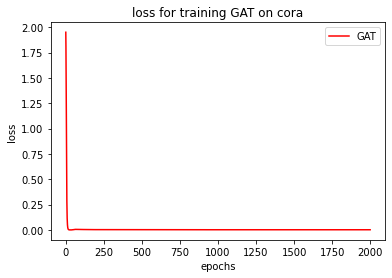

In [6]:
# 画出整体的loss曲线

p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on cora')

Text(0.5, 1.0, 'accuracy for training GAT on cora')

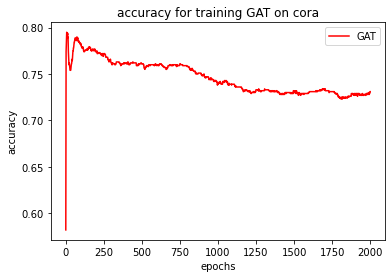

In [7]:
# 画出整体的accuracy曲线

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on cora')

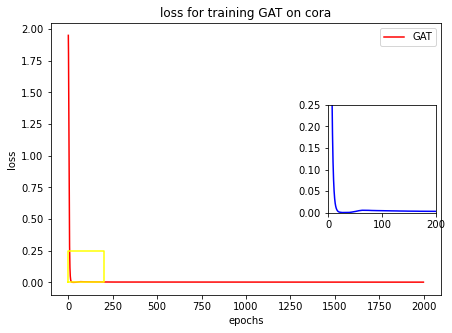

In [8]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的loss曲线
p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on cora')

# 显示放大的部分曲线
tx0 = 0
tx1 = 200
ty0 = 0.000
ty1 = 0.25
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y1, color='blue', ls='-')
axins.axis([0, 200, 0.000, 0.25])
plt.savefig("graphs/GAT_cora_loss.png")
pl.show()

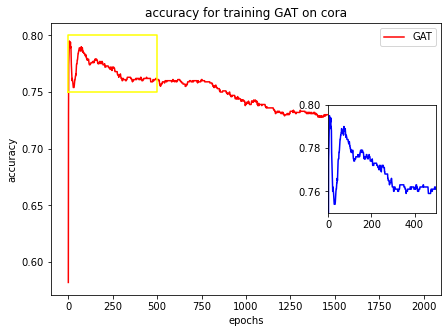

In [9]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的loss曲线

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on cora')

# 显示放大的部分曲线
tx0 = 0
tx1 = 500
#设置想放大区域的横坐标范围
ty0 = 0.75
ty1 = 0.80
#设置想放大区域的纵坐标范围
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y2, color='blue', ls='-')
axins.axis([0, 500, 0.75, 0.80])
plt.savefig("graphs/GAT_cora_accuracy.png")
pl.show()

In [10]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([1433, 64])
conv1.att 	 torch.Size([1, 8, 16])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 7])
conv2.att 	 torch.Size([1, 1, 14])
conv2.bias 	 torch.Size([7])
Optimizer's state_dict:
state 	 {1946461354568: {'step': 2000, 'exp_avg': tensor([[ 3.5590e-11, -7.7508e-11, -1.2150e-13,  ..., -2.1840e-08,
          1.0273e-07,  6.5857e-08],
        [ 4.8440e-10,  2.6309e-10,  2.4424e-11,  ..., -2.5337e-09,
          3.3107e-08,  1.9907e-08],
        [ 5.1514e-10, -6.8416e-10,  1.9481e-10,  ...,  2.6538e-09,
          5.6268e-08, -7.5356e-08],
        ...,
        [-5.1653e-12,  4.5036e-10, -1.1942e-09,  ...,  3.5465e-09,
          1.5807e-07,  5.8114e-08],
        [ 3.8529e-10,  1.6663e-10, -2.6095e-11,  ..., -5.7861e-09,
          1.1181e-07, -3.4585e-08],
        [-7.7846e-12, -6.8672e-11, -1.2387e-10,  ...,  2.8491e-09,
          1.5039e-07,  2.0961e-08]], device='cuda:0'), 'exp_avg_sq': tensor([[5.2987e-11, 4.3262e-12, 1.6259e

In [11]:
torch.save(model.state_dict(), "GATcora.pkl")

## CiteSeer

In [12]:
dataset = Planetoid(root='./dataset/Citeseer', name='CiteSeer')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

filename = 'LossAndAccuracy/GAT_Citeseer.txt'

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    with open(filename,'a') as f: # 'a'表示append,即在原来文件内容后继续写数据（不清楚原有数据）
        f.write('{:02d} {:.4f} {:.4f}\n'.format(epoch, loss, acc))

test model

In [14]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.6610


#### 绘制曲线

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data_cora =np.loadtxt("LossAndAccuracy/GAT_Citeseer.txt")

x = data_cora[:,0] # epoch
y1 = data_cora[:,1] # loss
y2 = data_cora[:,2] # accuracy

Text(0.5, 1.0, 'loss for training GAT on citeseer')

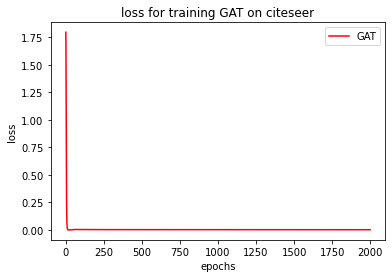

In [16]:
# 画出整体的loss曲线

p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on citeseer')

Text(0.5, 1.0, 'accuracy for training GAT on citeseer')

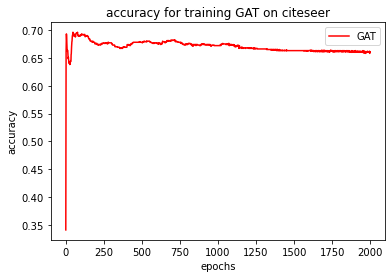

In [17]:
# 画出整体的accuracy曲线

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on citeseer')

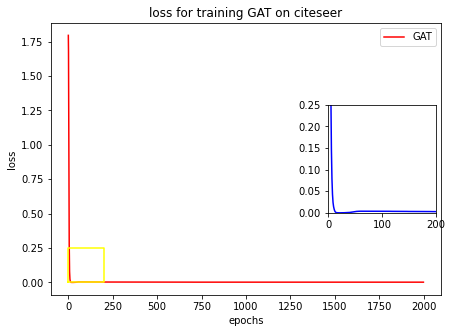

In [19]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的loss曲线
p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on citeseer')

# 显示放大的部分曲线
tx0 = 0
tx1 = 200
ty0 = 0.000
ty1 = 0.25
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y1, color='blue', ls='-')
axins.axis([0, 200, 0.000, 0.25])
plt.savefig("graphs/GAT_citeseer_loss.png")
pl.show()

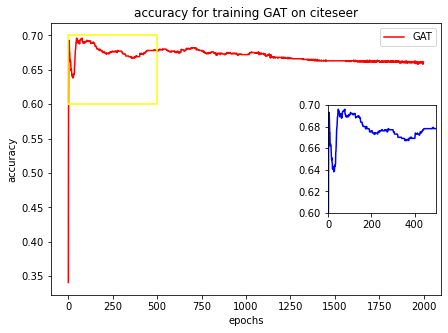

In [20]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的accuracy曲线
p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on citeseer')

# 显示放大的部分曲线
tx0 = 0
tx1 = 500
#设置想放大区域的横坐标范围
ty0 = 0.60
ty1 = 0.70
#设置想放大区域的纵坐标范围
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y2, color='blue', ls='-')
axins.axis([0, 500, 0.60, 0.70])
plt.savefig("graphs/GAT_citeseer_accuracy.png")
pl.show()

In [21]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([3703, 64])
conv1.att 	 torch.Size([1, 8, 16])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 6])
conv2.att 	 torch.Size([1, 1, 12])
conv2.bias 	 torch.Size([6])
Optimizer's state_dict:
state 	 {1946713060600: {'step': 2000, 'exp_avg': tensor([[-2.9314e-08, -2.0362e-08, -1.3348e-08,  ...,  3.2144e-08,
          1.0927e-08,  8.9690e-09],
        [-5.9118e-07,  4.7380e-07, -8.5783e-08,  ...,  1.3734e-07,
          1.6167e-07,  1.4622e-07],
        [ 9.4824e-10, -2.8742e-10,  5.5527e-11,  ..., -1.0995e-10,
          2.6753e-10, -8.6800e-11],
        ...,
        [-9.2917e-10, -2.5038e-09,  1.1204e-10,  ..., -3.6291e-10,
          4.0720e-10, -2.8666e-10],
        [-7.4442e-37, -4.2039e-45,  2.8026e-45,  ..., -7.0065e-45,
          5.6052e-45, -5.6052e-45],
        [ 8.1936e-11, -3.9068e-10,  1.6571e-10,  ...,  6.9142e-10,
         -2.7778e-10, -2.3973e-10]], device='cuda:0'), 'exp_avg_sq': tensor([[1.1433e-10, 1.6835e-09, 6.1873e

In [22]:
torch.save(model.state_dict(),'GATciteseer.pkl')

## Pubmed

In [23]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./dataset/Pubmed', name='Pubmed')

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

filename = 'LossAndAccuracy/GAT_Pubmed.txt'

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    with open(filename,'a') as f: # 'a'表示append,即在原来文件内容后继续写数据（不清楚原有数据）
        f.write('{:02d} {:.4f} {:.4f}\n'.format(epoch, loss, acc))

test model

In [26]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7650


#### 绘制曲线

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data_cora =np.loadtxt("LossAndAccuracy/GAT_Pubmed.txt")

x = data_cora[:,0] # epoch
y1 = data_cora[:,1] # loss
y2 = data_cora[:,2] # accuracy

Text(0.5, 1.0, 'loss for training GAT on pubmed')

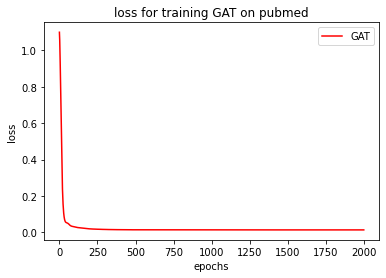

In [40]:
# 画出整体的loss曲线

p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on pubmed')

Text(0.5, 1.0, 'accuracy for training GAT on pubmed')

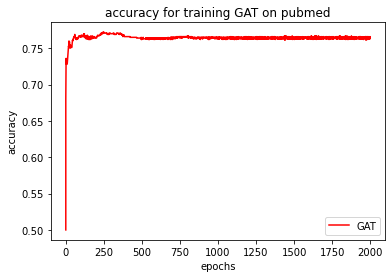

In [41]:
# 画出整体的accuracy曲线

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on pubmed')

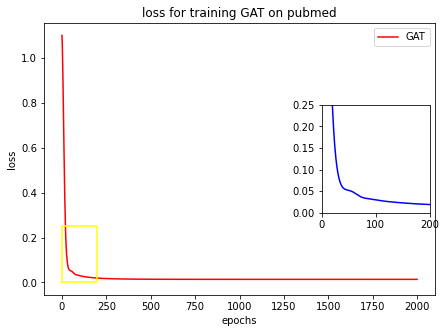

In [42]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的loss曲线
p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on pubmed')

# 显示放大的部分曲线
tx0 = 0
tx1 = 200
ty0 = 0.000
ty1 = 0.25
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y1, color='blue', ls='-')
axins.axis([0, 200, 0.00, 0.25])
plt.savefig("graphs/GAT_pubmed_loss.png")
pl.show()

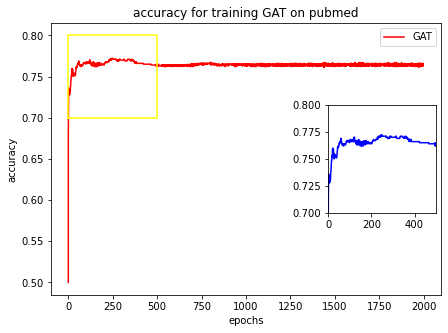

In [43]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的loss曲线

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on pubmed')

# 显示放大的部分曲线
tx0 = 0
tx1 = 500
#设置想放大区域的横坐标范围
ty0 = 0.70
ty1 = 0.80
#设置想放大区域的纵坐标范围
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y2, color='blue', ls='-')
axins.axis([0, 500, 0.70, 0.80])
plt.savefig("graphs/GAT_pubmed_accuracy.png")
pl.show()

In [32]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([500, 64])
conv1.att 	 torch.Size([1, 8, 16])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 3])
conv2.att 	 torch.Size([1, 1, 6])
conv2.bias 	 torch.Size([3])
Optimizer's state_dict:
state 	 {1946698287128: {'step': 2000, 'exp_avg': tensor([[-3.7222e-07,  3.2665e-07,  5.0619e-07,  ..., -3.6882e-07,
          6.5278e-07, -1.8217e-08],
        [-2.2879e-07,  1.5097e-07,  2.1615e-07,  ..., -1.5736e-07,
          9.7031e-09,  9.4604e-08],
        [-6.8919e-07,  4.3814e-07,  6.4445e-07,  ..., -4.1494e-07,
          3.4877e-08,  2.8156e-07],
        ...,
        [-2.3574e-07,  1.5150e-07,  2.2740e-07,  ..., -1.6768e-07,
          1.4318e-08,  9.5709e-08],
        [-2.6171e-07,  1.4654e-07,  1.8278e-07,  ..., -2.3397e-07,
          2.9731e-09,  8.4107e-08],
        [-2.7736e-07,  1.9807e-07,  2.9176e-07,  ..., -1.8802e-07,
          1.3052e-07,  1.3257e-07]], device='cuda:0'), 'exp_avg_sq': tensor([[1.0708e-08, 1.6484e-09, 5.6400e-0

In [33]:
torch.save(model.state_dict(),'GATpubmed.pkl')